# 02 - Pathfinder Survey Simulation

This notebook demonstrates a complete Pathfinder gradiometer survey simulation:

1. Load a scenario (buried objects defined in JSON)
2. Generate a walk path (zigzag survey pattern)
3. Simulate sensor readings with realistic noise
4. Export Pathfinder-compatible CSV
5. Visualize the anomaly map (2D matplotlib + 3D PyVista)
6. 3D subsurface cross-section
7. Compare to ground truth

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from geosim.scenarios.loader import load_scenario
from geosim.sensors.pathfinder import (
    PathfinderConfig, generate_zigzag_path, simulate_survey, export_csv,
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Load Scenario

Scenarios define the ground truth: what's buried where, the terrain, and soil properties.

In [2]:
# Load the scattered debris scenario
scenario_path = Path('..') / 'scenarios' / 'scattered-debris.json'
scenario = load_scenario(scenario_path)

print(f'Scenario: {scenario.name}')
print(f'Description: {scenario.description}')
print(f'Terrain: {scenario.terrain.x_extent[1]}m x {scenario.terrain.y_extent[1]}m')
print(f'Objects: {len(scenario.objects)}')
print()

for obj in scenario.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    print(f'  {obj.name}: pos={obj.position}, |m|={m_mag:.4f} A·m²')

Scenario: Scattered Aircraft Debris
Description: Multiple ferrous fragments at varying depths, simulating scattered aircraft wreckage. Tests multi-target discrimination.
Terrain: 30.0m x 30.0m
Objects: 6

  Engine block fragment: pos=[12.  15.  -1.5], |m|=1.6521 A·m²
  Wing spar section: pos=[18.  12.  -0.8], |m|=0.2484 A·m²
  Small fastener cluster: pos=[ 8.  20.  -0.3], |m|=0.0039 A·m²
  Landing gear strut: pos=[22.  22.  -2.5], |m|=0.4910 A·m²
  Instrument panel fragment: pos=[15.   8.  -0.5], |m|=0.0312 A·m²
  Propeller blade tip: pos=[25.  16.  -1.2], |m|=0.1058 A·m²


## 2. Ground Truth Map

Before running the survey, let's visualize what's actually buried.

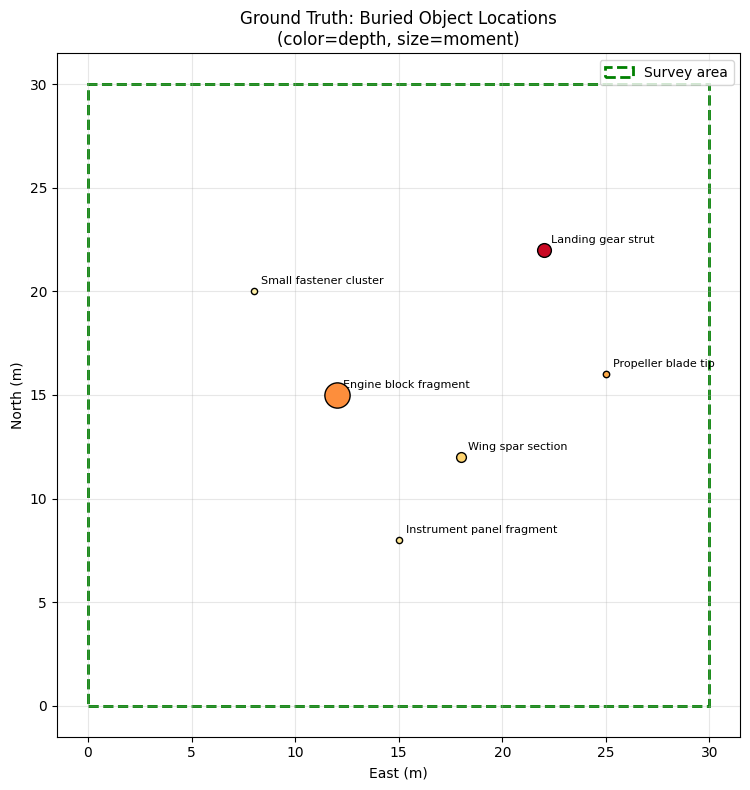

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot terrain extent
x_ext = scenario.terrain.x_extent
y_ext = scenario.terrain.y_extent
ax.add_patch(plt.Rectangle(
    (x_ext[0], y_ext[0]), x_ext[1]-x_ext[0], y_ext[1]-y_ext[0],
    fill=False, edgecolor='green', linewidth=2, linestyle='--', label='Survey area'
))

# Plot buried objects
for obj in scenario.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    size = max(20, m_mag * 200)  # Scale marker by moment
    ax.scatter(obj.position[0], obj.position[1], s=size,
              c=obj.position[2], cmap='YlOrRd_r', vmin=-3, vmax=0,
              edgecolors='black', linewidth=1, zorder=5)
    ax.annotate(obj.name.split('(')[0].strip(),
                (obj.position[0], obj.position[1]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Ground Truth: Buried Object Locations\n(color=depth, size=moment)')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

## 3. Generate Walk Path

Simulate a zigzag (boustrophedon) survey at 1 m/s with 1 m line spacing.

In [4]:
config = PathfinderConfig()
print(f'Pathfinder configuration:')
print(f'  Sensor pairs: {config.num_pairs}')
print(f'  Swath width: {config.swath_width} m')
print(f'  Sensor separation: {config.sensor_separation} m')
print(f'  Sample rate: {config.sample_rate} Hz')

x_min, x_max = scenario.terrain.x_extent
y_min, y_max = scenario.terrain.y_extent

positions, timestamps, headings = generate_zigzag_path(
    origin=(x_min, y_min),
    width=x_max - x_min,
    length=y_max - y_min,
    line_spacing=1.0,
    speed=1.0,
    sample_rate=config.sample_rate,
)

print(f'\nSurvey:')
print(f'  Total samples: {len(positions)}')
print(f'  Duration: {timestamps[-1]:.0f} seconds ({timestamps[-1]/60:.1f} minutes)')
print(f'  Path length: ~{timestamps[-1] * 1.0:.0f} m')

Pathfinder configuration:
  Sensor pairs: 4
  Swath width: 1.5 m
  Sensor separation: 0.35 m
  Sample rate: 10.0 Hz

Survey:
  Total samples: 9600
  Duration: 966 seconds (16.1 minutes)
  Path length: ~966 m


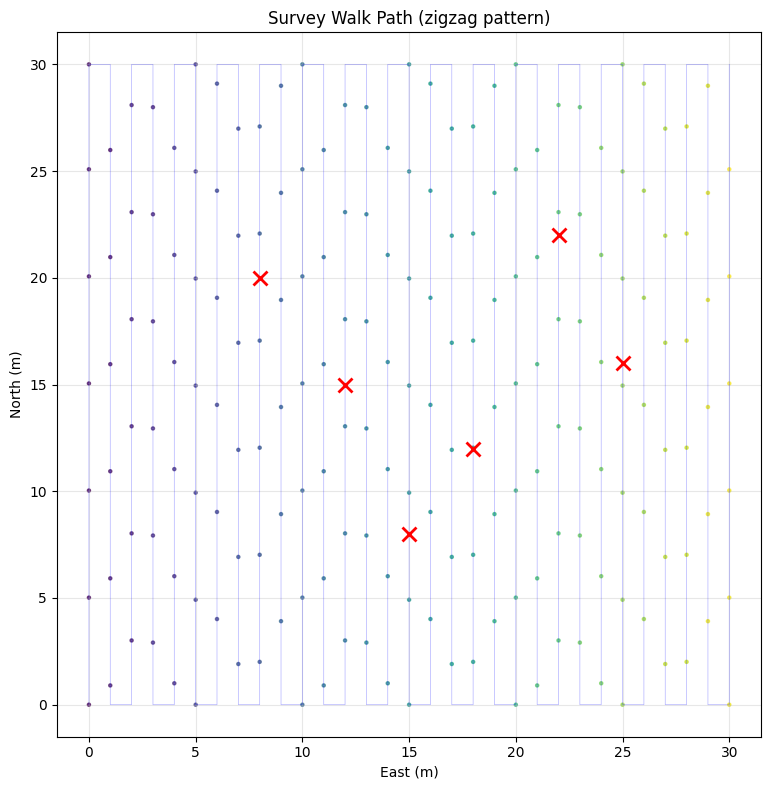

In [5]:
# Visualize the walk path
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(positions[:, 0], positions[:, 1], 'b-', alpha=0.3, linewidth=0.5)
ax.scatter(positions[::50, 0], positions[::50, 1], c=timestamps[::50],
           cmap='viridis', s=5, alpha=0.7)

for obj in scenario.objects:
    ax.plot(obj.position[0], obj.position[1], 'rx', markersize=10, markeredgewidth=2)

ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Survey Walk Path (zigzag pattern)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()

## 4. Run Simulation

Compute the magnetic field at each sensor position along the walk path,
add realistic noise, and produce Pathfinder-format CSV output.

In [6]:
sources = scenario.magnetic_sources
rng = np.random.default_rng(42)  # Reproducible results

# Run with noise
data = simulate_survey(
    positions, timestamps, headings, sources,
    config=config, rng=rng, add_noise=True,
)

# Also run without noise for comparison
data_clean = simulate_survey(
    positions, timestamps, headings, sources,
    config=config, add_noise=False,
)

print(f'Generated {len(data["timestamp"])} readings')
print(f'Gradient range (pair 1): {data["g1_grad"].min()} to {data["g1_grad"].max()} ADC counts')

Generated 9600 readings
Gradient range (pair 1): -8 to 66 ADC counts


## 5. Time Series

Gradient vs. time for each sensor pair — similar to what an operator would see on a live display.

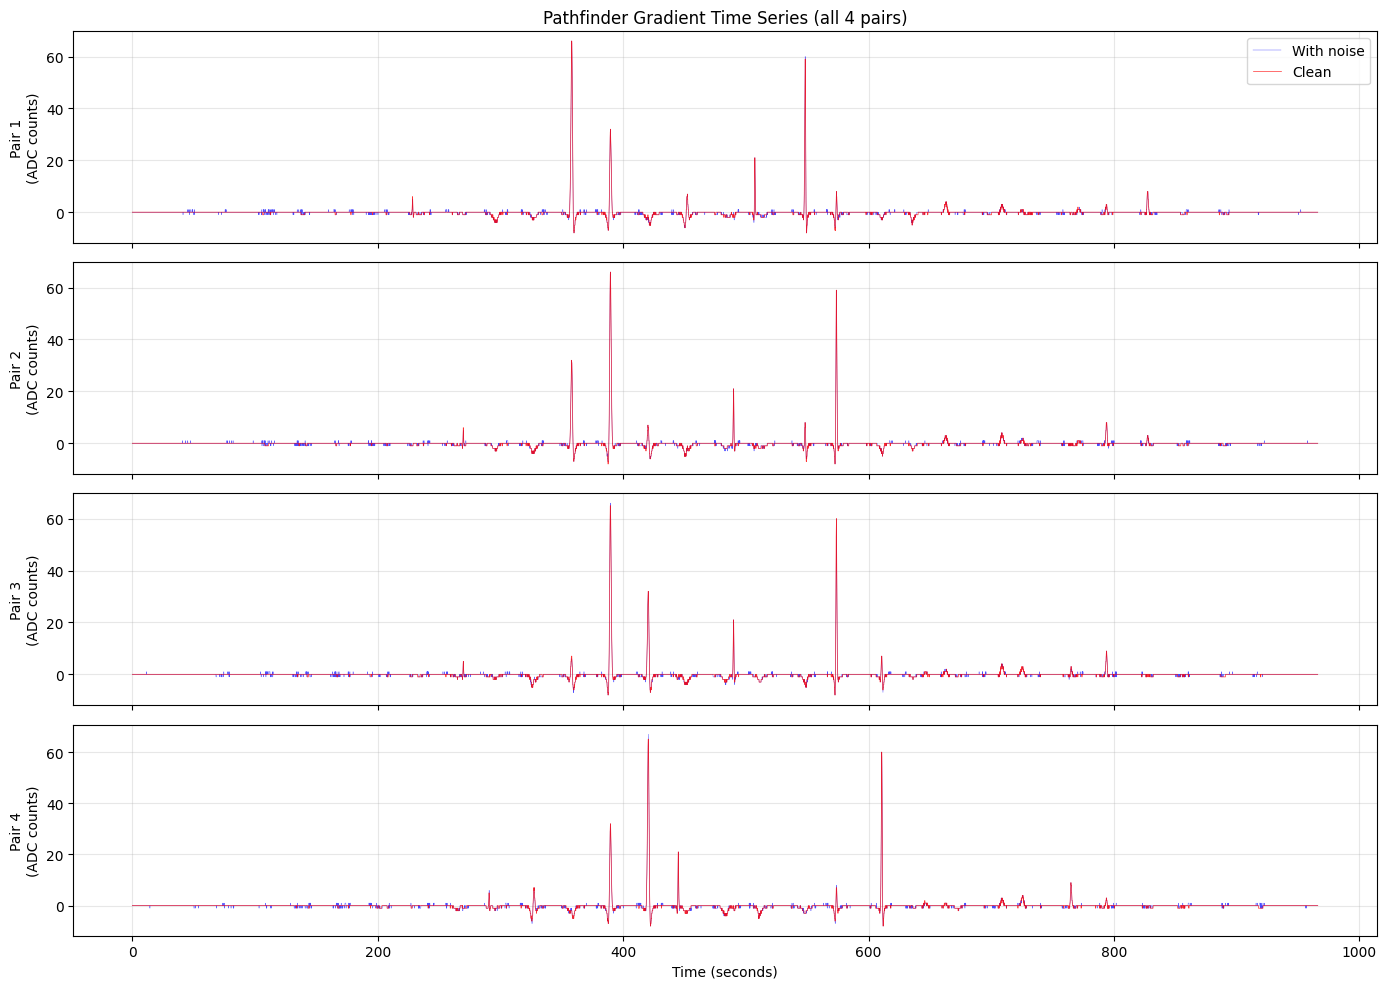

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

for i, ax in enumerate(axes):
    pair = i + 1
    t = data['timestamp'] / 1000
    ax.plot(t, data[f'g{pair}_grad'], 'b-', linewidth=0.3, alpha=0.7, label='With noise')
    ax.plot(t, data_clean[f'g{pair}_grad'], 'r-', linewidth=0.5, alpha=0.8, label='Clean')
    ax.set_ylabel(f'Pair {pair}\n(ADC counts)')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Time (seconds)')
axes[0].set_title('Pathfinder Gradient Time Series (all 4 pairs)')
plt.tight_layout()

## 6. Spatial Anomaly Map

The key output: gradient values plotted on their spatial positions.
This is what `visualize_data.py --map` produces.

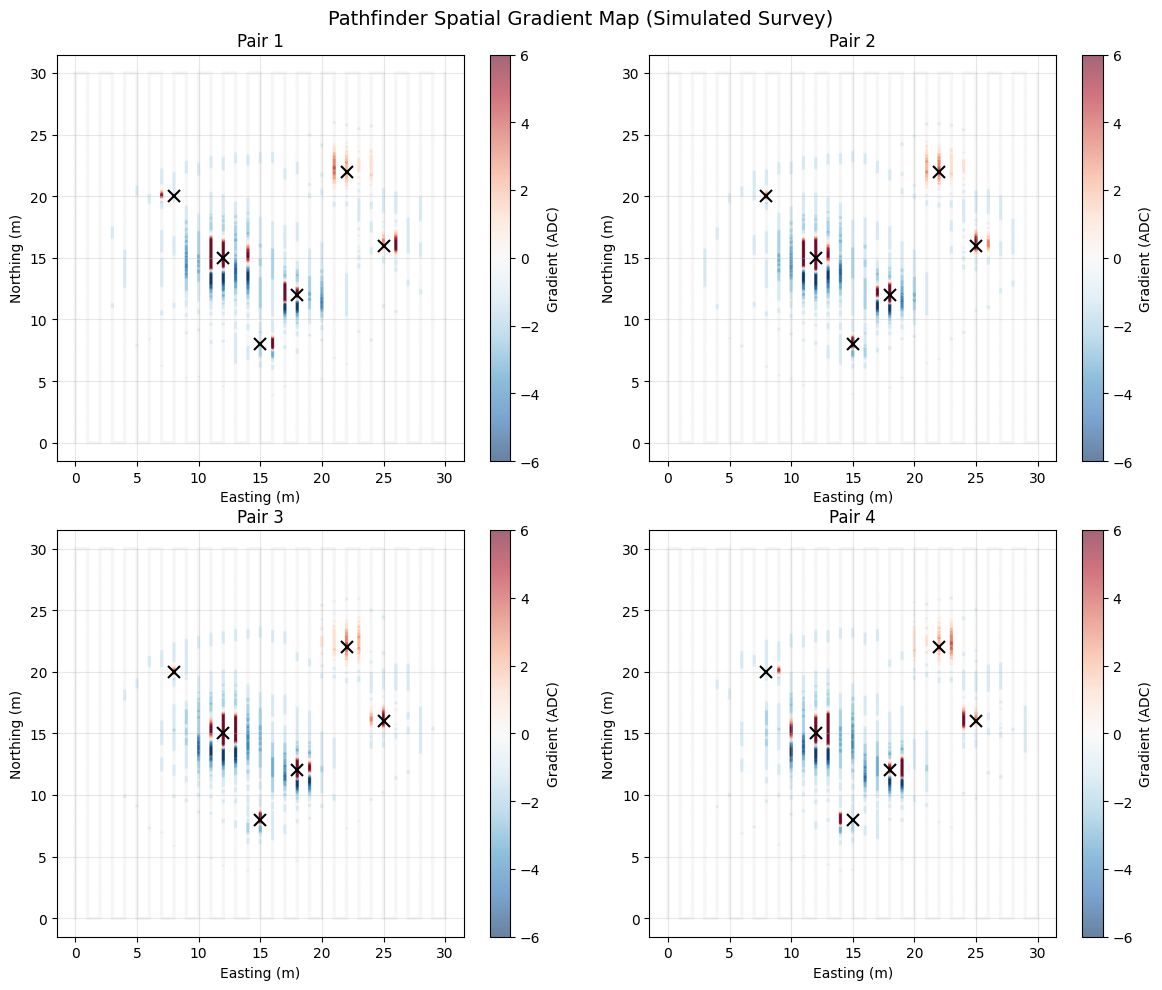

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Pathfinder Spatial Gradient Map (Simulated Survey)', fontsize=14)

for idx, ax in enumerate(axes.flat):
    pair = idx + 1
    grad = data_clean[f'g{pair}_grad']  # Clean for clarity

    sc = ax.scatter(
        data['lon'], data['lat'], c=grad,
        cmap='RdBu_r', s=2, alpha=0.6,
        vmin=-np.percentile(np.abs(grad), 99),
        vmax=np.percentile(np.abs(grad), 99),
    )
    plt.colorbar(sc, ax=ax, label='Gradient (ADC)')

    # Mark true target positions
    for obj in scenario.objects:
        ax.plot(obj.position[0], obj.position[1], 'kx',
                markersize=8, markeredgewidth=1.5)

    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(f'Pair {pair}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()

## 6b. 3D Survey Scene (PyVista)

Interactive 3D view showing terrain, buried objects, sensor path, and gradient anomaly map together.
This uses `geosim.viz.scenes.create_survey_scene()` — the reusable scene builder.

3D scene saved to: ../output/survey_scene_3d.png


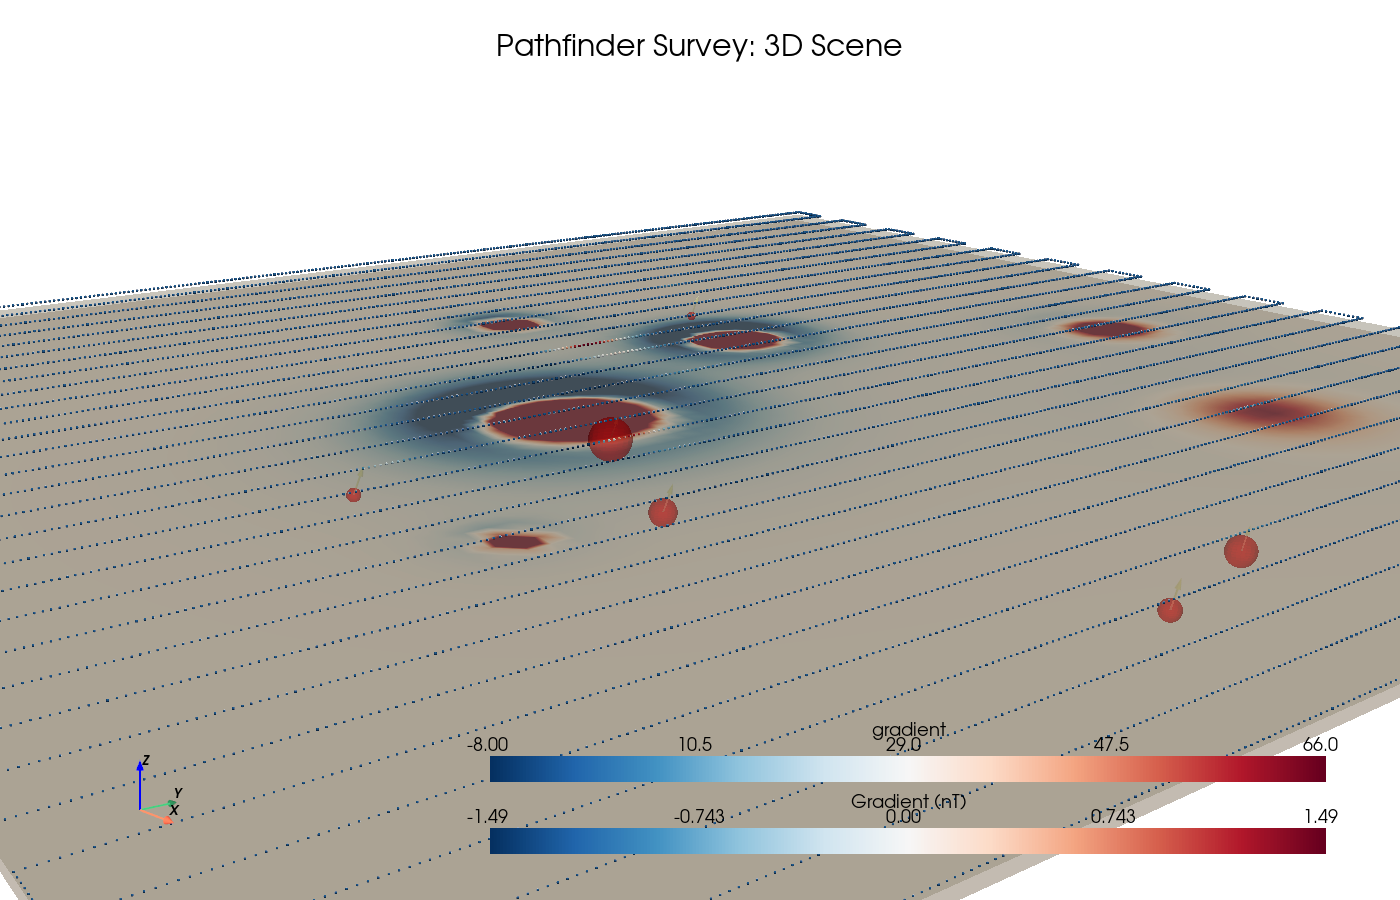

In [9]:
import pyvista as pv
from geosim.viz.scenes import create_survey_scene, render_to_image

# Use static rendering for notebook compatibility
pv.set_jupyter_backend('static')

# Build the complete 3D survey scene
# - Terrain surface (brown, semi-transparent)
# - Gradient anomaly map at sensor height (red-blue colormap)
# - Buried objects as red spheres (3x scale for visibility)
# - Dipole moment direction arrows (yellow)
# - Sensor walk path colored by gradient readings
plotter = create_survey_scene(
    scenario,
    positions=positions,
    gradient_data=data_clean['g1_grad'].astype(float),
    show_objects=True,
    show_terrain=True,
    show_gradient_map=True,
    show_soil_layers=False,
    show_moment_arrows=True,
    object_scale=3.0,
    off_screen=True,
)

# Set a good viewing angle — looking down and slightly from the side
plotter.camera_position = [
    (x_max * 1.3, y_min - 3, 8),   # Camera position
    ((x_min+x_max)/2, (y_min+y_max)/2, -1),  # Focal point
    (0, 0, 1),                       # View up
]
plotter.add_title('Pathfinder Survey: 3D Scene', font_size=12)

# Save static image
img_path = Path('..') / 'output' / 'survey_scene_3d.png'
img_path.parent.mkdir(exist_ok=True)
render_to_image(plotter, img_path, window_size=(1400, 900))
print(f'3D scene saved to: {img_path}')

plotter.show()

## 6c. Subsurface Cross-Section

A vertical slice through the survey area showing soil layers and buried objects in context.
This helps visualize *why* deep targets are harder to detect — the 1/r³ decay means
the gradient falls off rapidly with depth.

Cross-section saved to: ../output/subsurface_cross_section.png


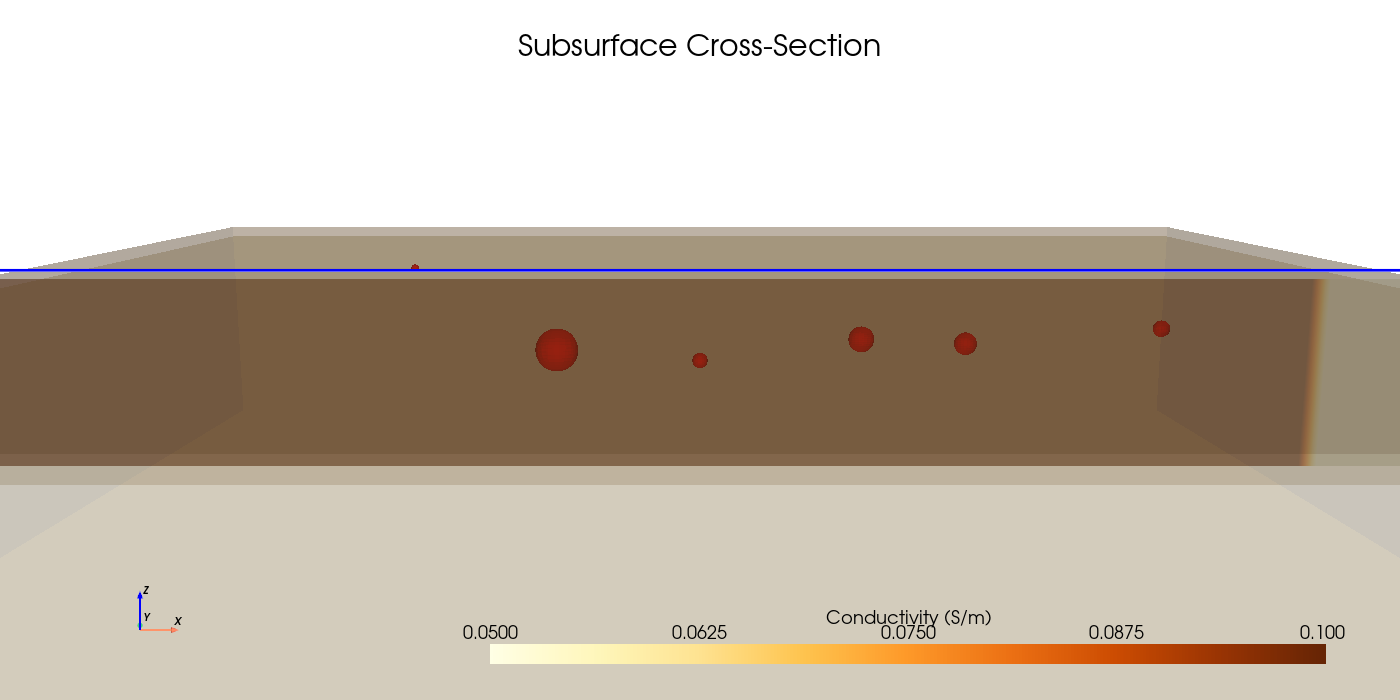

In [10]:
from geosim.viz.terrain import create_terrain_mesh, create_soil_layers, create_subsurface_slice
from geosim.viz.objects import create_buried_objects

plotter2 = pv.Plotter(off_screen=True)
plotter2.set_background('white')

# Terrain surface
terrain = create_terrain_mesh(scenario)
plotter2.add_mesh(terrain, color='#8B7355', opacity=0.3, label='Ground surface')

# Soil layers as transparent boxes
layers = create_soil_layers(scenario, opacity=0.15)
layer_colors = ['#D2B48C', '#8B6914', '#654321']  # tan → dark brown
for i, layer_mesh in enumerate(layers):
    plotter2.add_mesh(
        layer_mesh, opacity=0.15,
        color=layer_colors[i % len(layer_colors)],
    )

# Buried objects — larger scale for cross-section view
objects = create_buried_objects(scenario, scale_factor=3.0)
for mesh, props in objects:
    plotter2.add_mesh(
        mesh, color='red', opacity=0.8,
        label=f"{props['name']} ({props['depth']:.1f}m)",
    )

# Vertical cross-section slice through the middle
y_mid = (y_min + y_max) / 2
xslice = create_subsurface_slice(scenario, y_position=y_mid, depth=4.0, resolution=80)
plotter2.add_mesh(
    xslice, scalars='conductivity', cmap='YlOrBr',
    opacity=0.6, scalar_bar_args={'title': 'Conductivity (S/m)'},
)

# Add a horizontal line at sensor height for reference
sensor_line = pv.Line(
    (x_min, y_mid, 0.175), (x_max, y_mid, 0.175),
)
plotter2.add_mesh(sensor_line, color='blue', line_width=3, label='Sensor height')

plotter2.camera_position = [
    ((x_min+x_max)/2, y_min - 12, 3),
    ((x_min+x_max)/2, y_mid, -1.5),
    (0, 0, 1),
]
plotter2.add_title('Subsurface Cross-Section', font_size=12)
plotter2.add_axes()

# Save
img_path2 = Path('..') / 'output' / 'subsurface_cross_section.png'
render_to_image(plotter2, img_path2, window_size=(1400, 700))
print(f'Cross-section saved to: {img_path2}')

plotter2.show()

In [11]:
output_path = Path('..') / 'output' / 'simulated_survey.csv'
output_path.parent.mkdir(exist_ok=True)

export_csv(data, output_path, num_pairs=4)
print(f'CSV exported to: {output_path}')
print(f'File size: {output_path.stat().st_size / 1024:.1f} KB')

# Show first few lines
with open(output_path) as f:
    for i, line in enumerate(f):
        if i >= 5:
            print('...')
            break
        print(line.rstrip())

CSV exported to: ../output/simulated_survey.csv
File size: 510.6 KB
timestamp,lat,lon,g1_top,g1_bot,g1_grad,g2_top,g2_bot,g2_grad,g3_top,g3_bot,g3_grad,g4_top,g4_bot,g4_grad
0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
100,0.100334,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
200,0.200669,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
301,0.301003,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
...


## 8. Detection Summary

Compare detected anomalies to ground truth to assess Pathfinder's detection capability.

In [12]:
# For each target, find the peak gradient reading from the nearest sensor pair
print(f"{'Object':<30} {'Depth':>6} {'Moment':>10} {'Peak Grad':>12} {'Detected?':>10}")
print('-' * 72)

noise_threshold = 20  # ADC counts (from Pathfinder calibration spec)

for obj in scenario.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    depth = abs(obj.position[2])

    # Find peak |gradient| near this object
    dx = data['lon'] - obj.position[0]
    dy = data['lat'] - obj.position[1]
    dist = np.sqrt(dx**2 + dy**2)
    nearby = dist < 2.0  # within 2m

    if nearby.any():
        peak_grad = max(
            np.abs(data_clean[f'g{p}_grad'][nearby]).max()
            for p in range(1, 5)
        )
    else:
        peak_grad = 0

    detected = 'YES' if peak_grad > noise_threshold * 3 else 'marginal' if peak_grad > noise_threshold else 'no'
    print(f"{obj.name:<30} {depth:>5.1f}m {m_mag:>9.4f}  {peak_grad:>10.0f} ADC  {detected:>10}")

Object                          Depth     Moment    Peak Grad  Detected?
------------------------------------------------------------------------
Engine block fragment            1.5m    1.6521          66 ADC         YES
Wing spar section                0.8m    0.2484          60 ADC    marginal
Small fastener cluster           0.3m    0.0039           6 ADC          no
Landing gear strut               2.5m    0.4910           4 ADC          no
Instrument panel fragment        0.5m    0.0312          21 ADC    marginal
Propeller blade tip              1.2m    0.1058           9 ADC          no


## Key Takeaways

1. The simulation produces **realistic Pathfinder CSV data** that can be loaded by existing tools
2. Large, shallow targets produce strong, clear anomalies; deep or small targets may be below threshold
3. The zigzag survey pattern provides full area coverage
4. Noise affects detection of marginal targets but doesn't mask strong anomalies
5. **3D visualization** (`geosim.viz`) shows the full spatial context: terrain, buried objects, gradient anomalies, and sensor path in one scene
6. The **subsurface cross-section** reveals why depth matters — the 1/r³ decay law limits Pathfinder's reach

Next: [03-hirt-ert-forward.ipynb](03-hirt-ert-forward.ipynb) — HIRT ERT forward modeling (Phase 2)